In [ ]:
import json
from pathlib import Path
import os
import re
import sys
import time
import itertools
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from nltk.util import ngrams
from wordcloud import WordCloud
from pywykop3 import WykopAPI
from pyvis.network import Network

In [ ]:
#any wykop users can get the keys, just create an account
key = os.getenv("wykop_api_key") 
secret = os.getenv("wykop_secret_key")

if not key or not secret:
    raise ValueError("No key or secret in the env variables!")

print(f"key: {key[:5]}***")  # Test purpose

key: w5672***


In [3]:
api = WykopAPI(key=key, secret=secret)

In [ ]:
base_path = os.getenv("wykop_file_path")
#define your file path in environmental variables or just add it in regular way

In [ ]:
tag = "wybory"
year = 2025
month = 6
max_pages = 400       # for safety
target_unique = 10000 # we can get max 10k posts

all_posts = []
seen_ids = set()

for page in range(1, max_pages + 1):
    print(f"\rFetching page {page}/{max_pages}... Collected: {len(all_posts)} unique posts", end="")

    entries = api.get_tag_stream(
        tag_name=tag,
        sort="all",
        type_of_content="all",
        year=year,
        month=month,
        page=page,
        page_count=1
    )

    if not entries:
        print("\nNo more entries from API.")
        break

    for e in entries:
        post_id = e.get("id")
        if post_id not in seen_ids:
            seen_ids.add(post_id)
            all_posts.append(e)

        # stop when we reach target number of unique posts
        if len(all_posts) >= target_unique:
            break

    if len(all_posts) >= target_unique:
        print("\nReached target number of unique posts.")
        break

    time.sleep(0.5)

print(f"\n\nTotal unique posts collected: {len(all_posts)}")

# Save to JSON
# Change path if needed, file name as well!
path = os.path.join(base_path, "wybory_june_2025_clean.json") 
with open(path, "w", encoding="utf-8") as f:
    json.dump(all_posts, f, ensure_ascii=False, indent=2)

print(f"Saved to: {path}")

Fetching page 1/400... Collected: 0 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 2/400... Collected: 25 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 3/400... Collected: 50 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 4/400... Collected: 75 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 5/400... Collected: 100 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 6/400... Collected: 125 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 7/400... Collected: 150 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 8/400... Collected: 175 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 9/400... Collected: 200 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 10/400... Collected: 225 unique postsres.pagination={'per_page': 25, 'total': 10000}
Fetching page 11/400... 

In [ ]:
file_path = base_path / "wybory_june_2025_clean.json"
# Load posts from JSON
with open(file_path, "r", encoding="utf-8") as f:
    posts = json.load(f)

# Extract and sort dates
dates = [
    datetime.strptime(p["created_at"], "%Y-%m-%d %H:%M:%S")
    for p in posts
    if "created_at" in p
]

if dates:
    min_date = min(dates).strftime("%Y-%m-%d")
    max_date = max(dates).strftime("%Y-%m-%d")
    print(f"Posts date range: {min_date} -> {max_date}")
else:
    print("No dates found.")

Posts date range: 2025-05-31 -> 2025-07-19


In [ ]:
# Load cleaned JSON
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Only posts (entry)
posts = [item for item in data if item.get("resource") == "entry"]

df = pd.DataFrame([
    {"id": p.get("id"), "created_at": p.get("created_at")}
    for p in posts
])

total_posts = len(df)
unique_ids = df["id"].nunique()
duplicates = total_posts - unique_ids

print(f"Total posts in file: {total_posts}")
print(f"Unique post IDs: {unique_ids}")
print(f"Duplicate posts: {duplicates}")

Total posts in file: 9930
Unique post IDs: 9930
Duplicate posts: 0


In [6]:
data[:1]

[{'id': 82411215,
  'slug': 'wybory-bekazlewactwa-polska-imigranci',
  'author': {'username': 'Nemayu',
   'gender': 'm',
   'company': False,
   'avatar': 'https://wykop.pl/cdn/c3397992/Nemayu_OpwEKCGaHZ.jpg',
   'status': 'active',
   'color': 'orange',
   'verified': False,
   'rank': {'position': None, 'trend': 0},
   'blacklist': False,
   'follow': False,
   'donation': None,
   'note': False,
   'online': False},
  'device': '',
  'created_at': '2025-07-19 23:25:51',
  'voted': 0,
  'content': '#wybory #bekazlewactwa #polska #imigranci',
  'media': {'photo': None,
   'embed': {'key': 'OrN2xZpnEJeXMLBmWlzv5KlM8n6gj8q143g76DYay9dQV0kRAb',
    'type': 'youtube',
    'thumbnail': 'https://wykop.pl/cdn/c3201142/79a247eae43122d9373eae50c92e6ee8c8a35e21c5049f9f1d3497dfd37d3a9c.jpg?author=Nemayu&auth=616c93ae7d7b9e4e98fa9e9ef3b06359',
    'url': 'https://www.youtube.com/watch?v=F9OruEpeFcs',
    'age_category': 'all',
    'video_metadata': None,
    'commercial': False},
   'survey': No

In [ ]:
# ---- STOPWORDS ----
polish_stopwords = {
    "i", "oraz", "a", "w", "z", "na", "że", "to", "nie", "tak", "jest",
    "się", "o", "po", "jak", "ale", "dla", "co", "od", "za", "czy", "by",
    "tylko", "być", "go", "też", "bo", "u", "są", "który", "która", "które",
    "już", "ma", "przez", "było", "była", "temu", "więc", "mnie", "ich",
    "także", "ten", "tym", "nawet", "którzy", "sobie", "nikt", "dalej",
    "będzie", "tego", "jeszcze", "teraz", "może", "sie",
    "żeby", "tam", "trzeba", "mam"
}

# ---- CLEANING & TOKENIZATION ----
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"#\w+", "", text)       # remove hashtags
    text = re.sub(r"@\w+", "", text)       # remove mentions
    text = re.sub(r"[^a-ząćęłńóśźż]+", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in polish_stopwords and len(t) > 2]
    return tokens

# ---- LOAD CLEAN JSON ----
file_path = base_path / "wybory_june_2025_clean.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

posts = [item for item in data if item.get("resource") == "entry"]
df = pd.DataFrame([{"content": p.get("content")} for p in posts if p.get("content")])

# ---- TOP WORDS ----
all_tokens = []
for content in df["content"]:
    all_tokens.extend(clean_and_tokenize(content))

top_words = Counter(all_tokens).most_common(30)
print("\nTop 30 most common words (cleaned, no lemmatization):")
for word, count in top_words:
    print(f"{word}: {count}")

# ---- TOP BIGRAMS ----
all_bigrams = []
for content in df["content"]:
    tokens = clean_and_tokenize(content)
    all_bigrams.extend(ngrams(tokens, 2))

top_bigrams = Counter(all_bigrams).most_common(30)
print("\nTop 30 most common bigrams (cleaned, no lemmatization):")
for bigram, count in top_bigrams:
    print(f"{' '.join(bigram)}: {count}")


Top 30 most common words (cleaned, no lemmatization):
wybory: 626
pis: 498
nawrocki: 495
trzaskowski: 469
głosów: 440
nawrockiego: 409
ludzie: 380
lat: 369
trzaskowskiego: 355
wyborów: 325
kto: 307
komisji: 299
trzask: 290
nic: 283
prezydenta: 282
tych: 279
ktoś: 276
był: 271
wygrał: 270
gdzie: 269
niż: 268
ludzi: 266
wynik: 264
was: 262
można: 262
polski: 257
głosy: 255
wyniki: 249
wyborach: 248
kraju: 233

Top 30 most common bigrams (cleaned, no lemmatization):
trzask nawr: 211
late poll: 134
prince polo: 92
exit poll: 74
głosów symulacja: 70
symulacja trzask: 70
nawr wynik: 70
wynik trzask: 70
nawr brakujące: 70
brakujące głosy: 70
głosy trzask: 70
karol nawrocki: 69
nawr komisja: 69
rafał trzaskowski: 65
drugiej turze: 43
pierwszej turze: 37
rafała trzaskowskiego: 36
dwa lata: 36
drugiej strony: 35
kto wygra: 34
tych wyborów: 31
gosia gosia: 31
karola nawrockiego: 29
trzaskowski przegrał: 27
wynik wyborów: 25
nawrocki wygrał: 24
cześć giniemy: 24
wygrał nawrocki: 23
wybory prezyde

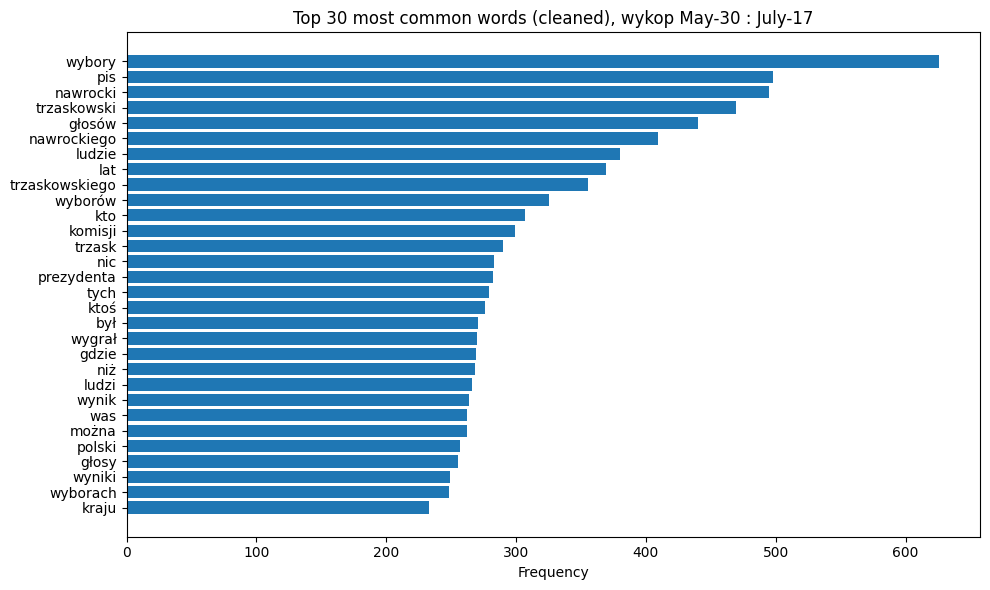

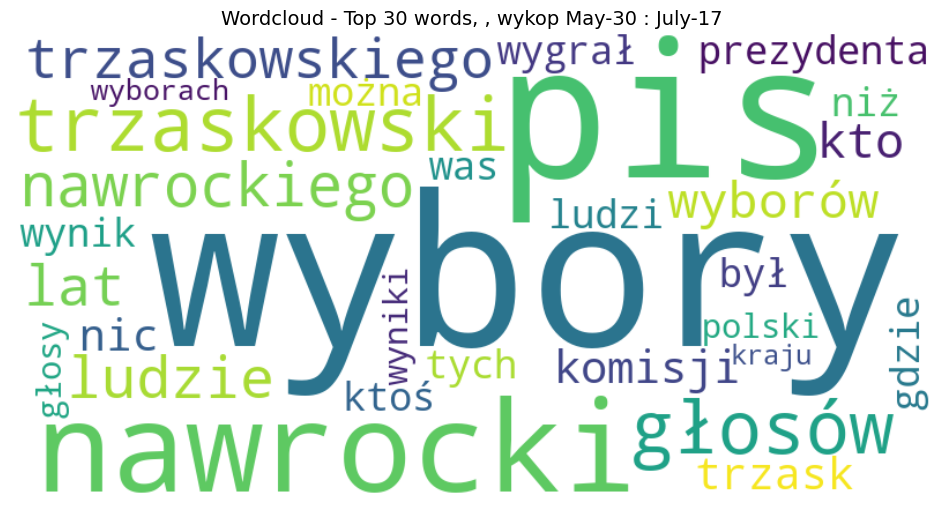

In [7]:
posts = [item for item in data if item.get("resource") == "entry"]

# Generate all_tokens
all_tokens = []
for p in posts:
    if p.get("content"):
        all_tokens.extend(clean_and_tokenize(p["content"]))

# ---- TOP 30 WORDS ----
top_30_words = Counter(all_tokens).most_common(30)
words, counts = zip(*top_30_words)

# ---- WYKRES SŁUPKOWY ----
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1]) 
plt.xlabel("Frequency")
plt.title("Top 30 most common words (cleaned), wykop May-30 : July-17")
plt.tight_layout()
plt.show()

# ---- WORDCLOUD ----
word_freq_dict = dict(top_30_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=30
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Top 30 words, , wykop May-30 : July-17", fontsize=14)
plt.show()

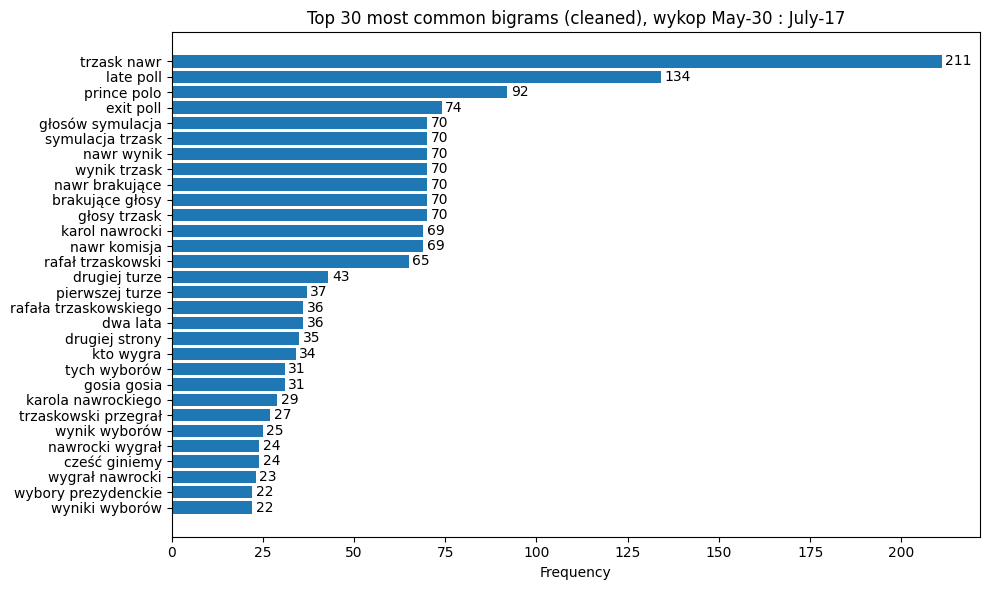

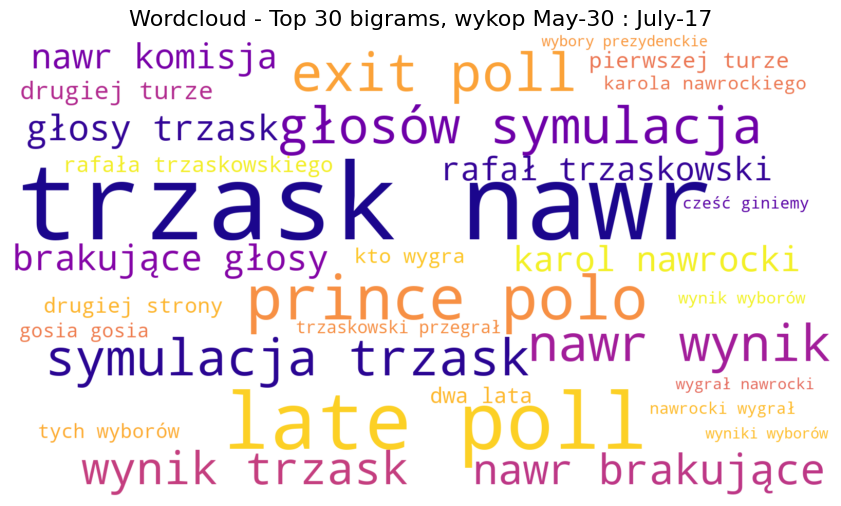

In [8]:
# ---- GENERATE BIGRAMS ----
all_bigrams = []
for p in posts:
    if p.get("content"):
        tokens = clean_and_tokenize(p["content"])
        all_bigrams.extend(ngrams(tokens, 2))

# Count and convert to "word1 word2" format
top_30_bigrams = Counter(all_bigrams).most_common(30)
bigrams_str = [(" ".join(b), c) for b, c in top_30_bigrams]
bigram_words, bigram_counts = zip(*bigrams_str)

# ---- WYKRES SŁUPKOWY ----
plt.figure(figsize=(10, 6))
bars = plt.barh(bigram_words[::-1], bigram_counts[::-1])
plt.xlabel("Frequency")
plt.title("Top 30 most common bigrams (cleaned), wykop May-30 : July-17")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1,                   
             bar.get_y() + bar.get_height()/2, 
             f"{int(width)}", va="center")

plt.tight_layout()
plt.show()

# ---- WORDCLOUD ----
wordcloud_bigrams = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    colormap="plasma",     #alternative: inferno
    max_words=30,
    prefer_horizontal=0.9,
    relative_scaling=0.7,    
    font_step=1,             
    contour_color="black",
    contour_width=1
).generate_from_frequencies(
    { " ".join(bg): count for bg, count in top_30_bigrams }
)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_bigrams, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Top 30 bigrams, wykop May-30 : July-17", fontsize=16)
plt.show()

In [9]:
tag_counter = Counter()

for post in data:
    text = post.get("content","")

    tags = re.findall(r"#\w+", text.lower())

    for tag in tags:
        if tag != "#wybory":
            tag_counter[tag] += 1
print(tag_counter.most_common(20))

[('#heheszki', 304), ('#bekazlewactwa', 219), ('#bekazpisu', 181), ('#polska', 180), ('#neuropa', 122), ('#kanalzero', 113), ('#przegryw', 104), ('#bazarek', 87), ('#4konserwy', 60), ('#bekazpodludzi', 60), ('#nawrocki', 60), ('#wykop', 60), ('#trzaskowski', 58), ('#nieruchomosci', 51), ('#mecz', 49), ('#afera', 48), ('#humorobrazkowy', 44), ('#bekazprawakow', 43), ('#famemma', 40), ('#takaprawda', 38)]


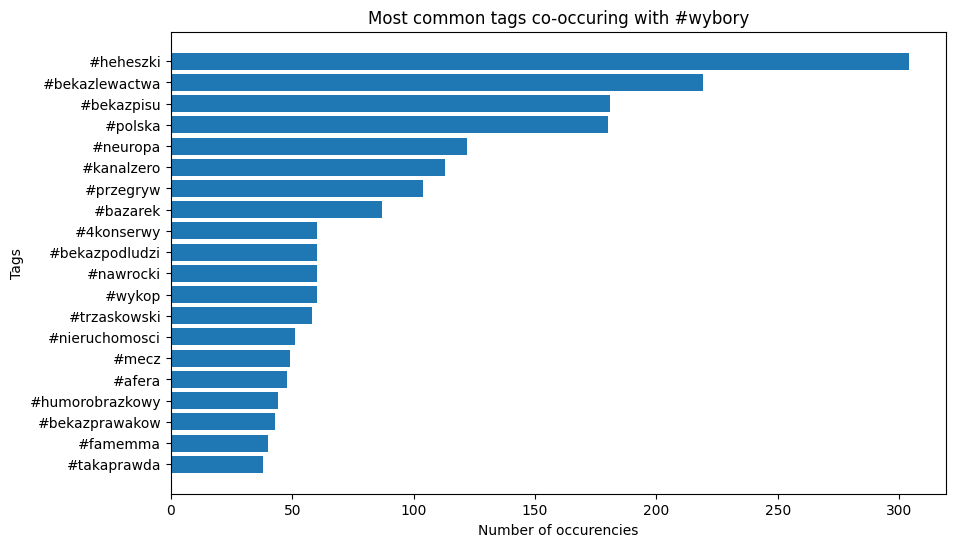

In [10]:
tags_data = tag_counter.most_common(20)

tags, counts = zip(*tags_data)

plt.figure(figsize=(10,6))
plt.barh(tags, counts)
plt.xlabel("Number of occurencies")
plt.ylabel("Tags")
plt.title("Most common tags co-occuring with #wybory")
plt.gca().invert_yaxis()
plt.tight_layout
plt.show()

In [11]:
user_counter = Counter()

for post in data:
    author_info = post.get("author", {})
    username = author_info.get("username","unknown")
    user_counter[username] += 1

top_users = user_counter.most_common(20)
print(top_users)


[('NaczelnyWoody', 76), ('saviour', 64), ('wiktor-wkpl', 63), ('Mein_Kraft', 59), ('matthewonthego', 59), ('Z.....a', 54), ('niemczarek_owiecki', 53), ('roman_erotoman', 47), ('idzpanwuj', 45), ('Morritz', 43), ('raul7788', 43), ('Epiktetlol', 42), ('Megasuper', 42), ('bezzebnywampir', 38), ('DzonyDzony', 36), ('dzialoZaglady', 32), ('kukold', 32), ('maciorqa', 32), ('szyderczy_szczur', 31), ('josedra52', 31)]


In [12]:
print("Top 20 most active users (author posts):\n")
for i, (user, count) in enumerate(top_users, start=1):
    print(f"• {i}. {user} - {count} posts")

Top 20 most active users (author posts):

• 1. NaczelnyWoody - 76 posts
• 2. saviour - 64 posts
• 3. wiktor-wkpl - 63 posts
• 4. Mein_Kraft - 59 posts
• 5. matthewonthego - 59 posts
• 6. Z.....a - 54 posts
• 7. niemczarek_owiecki - 53 posts
• 8. roman_erotoman - 47 posts
• 9. idzpanwuj - 45 posts
• 10. Morritz - 43 posts
• 11. raul7788 - 43 posts
• 12. Epiktetlol - 42 posts
• 13. Megasuper - 42 posts
• 14. bezzebnywampir - 38 posts
• 15. DzonyDzony - 36 posts
• 16. dzialoZaglady - 32 posts
• 17. kukold - 32 posts
• 18. maciorqa - 32 posts
• 19. szyderczy_szczur - 31 posts
• 20. josedra52 - 31 posts


In [13]:
comment_counter = Counter()

for post in data:
    comments = post.get("comments", {}).get("items", [])

    for comment in comments:
        author = comment.get("author", {}).get("username", "unknown")
        comment_counter[author] += 1

top_commenters = comment_counter.most_common(20)
print("Top 20 most active commenters:\n")
for i, (user, count) in enumerate(top_commenters, start=1):
    print(f"• {i}. {user} — {count} comments")

Top 20 most active commenters:

• 1. Mein_Kraft — 155 comments
• 2. Nighthuntero — 71 comments
• 3. Morritz — 61 comments
• 4. korona_swirus — 58 comments
• 5. vZGLSjkzfn — 54 comments
• 6. Z.....a — 48 comments
• 7. NaczelnyWoody — 43 comments
• 8. winsxspl — 41 comments
• 9. Rakky — 41 comments
• 10. P.....r — 41 comments
• 11. niecodziennyszczon — 40 comments
• 12. Makavlani — 39 comments
• 13. Vinizius — 37 comments
• 14. d.....t — 36 comments
• 15. harcerz — 35 comments
• 16. gwda — 35 comments
• 17. eSUBA94 — 34 comments
• 18. Atomus — 34 comments
• 19. sameowoce — 33 comments
• 20. matti-nn — 30 comments


In [15]:
pair_counter = Counter()

for post in data:
    tags = post.get("tags", [])
    tags = [t.lower() for t in tags if t.lower() != "wybory"]
    
    for pair in itertools.combinations(sorted(set(tags)), 2):
        pair_counter[pair] += 1

# Only top to avoid crowd
top_pairs = pair_counter.most_common(100)

# GRAPH
net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black")

for (tag1, tag2), weight in top_pairs:
    net.add_node(tag1, label=tag1, size=10)
    net.add_node(tag2, label=tag2, size=10)
    net.add_edge(tag1, tag2, value=weight, title=f"{weight} wspólnych postów")

net.force_atlas_2based()  

net.write_html("tag_network.html")